###### Library Import

In [2]:
import pandas as pd
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

###### GPU Status

In [97]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11044161067001968785
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8214894135191474846
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


###### Image & Size 확인

Image Width: 512
Image Height: 512


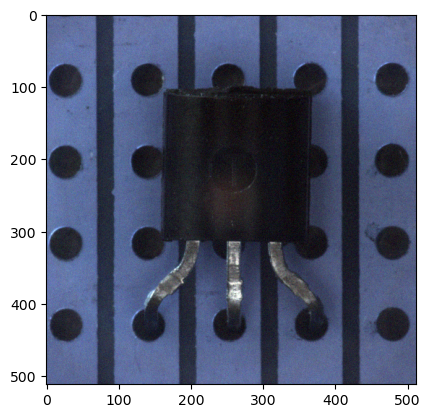

In [10]:
test_image_path = './train/TRAIN_000.png'

test_image = cv2.imread(test_image_path)

height, width, channels = test_image.shape

plt.imshow(test_image)

print("Image Width:", width)
print("Image Height:", height)

###### Train, Test Data Load

In [3]:
train_csv = './train.csv'
test_csv = './test.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(train_df.head())
print(test_df.head())

          id               img_path  label
0  TRAIN_000  ./train/TRAIN_000.png      0
1  TRAIN_001  ./train/TRAIN_001.png      0
2  TRAIN_002  ./train/TRAIN_002.png      0
3  TRAIN_003  ./train/TRAIN_003.png      0
4  TRAIN_004  ./train/TRAIN_004.png      0
         id             img_path
0  TEST_000  ./test/TEST_000.png
1  TEST_001  ./test/TEST_001.png
2  TEST_002  ./test/TEST_002.png
3  TEST_003  ./test/TEST_003.png
4  TEST_004  ./test/TEST_004.png


###### Data Shape

In [4]:
print(train_df.shape)
print(test_df.shape)

(213, 3)
(100, 2)


* train 데이터는 총 213개의 행을 가지고 있다.
* 모델을 학습시키기에 데이터가 충분한가?

In [8]:
print(train_df['label'].value_counts())

0    213
Name: label, dtype: int64


* 1-Class 데이터임을 확인할 수 있다.
* 모두 정상 데이터이며 정상 데이터만을 학습해 이상 데이터 판단

###### ROI 좌표를 설정하여 특정 영역만 적용할 수 있도록 설정

In [11]:
import cv2

# 마우스 이벤트 콜백 함수
def select_roi(event, x, y, flags, param):
    global roi_points, cropping

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_points = [(x, y)]
        cropping = True

    elif event == cv2.EVENT_LBUTTONUP:
        roi_points.append((x, y))
        cropping = False

        # ROI 영역 표시
        cv2.rectangle(image_copy, roi_points[0], roi_points[1], (0, 255, 0), 2)
        cv2.imshow("Select ROI", image_copy)

# 이미지 로드
image = cv2.imread(test_image_path)
image_copy = image.copy()

# ROI 좌표 초기화
roi_points = []
cropping = False

# 윈도우 생성 및 마우스 이벤트 콜백 함수 등록
cv2.namedWindow("Select ROI")
cv2.setMouseCallback("Select ROI", select_roi)

# ROI 선택 대기
while True:
    cv2.imshow("Select ROI", image_copy)
    key = cv2.waitKey(1) & 0xFF

    # ROI 선택 완료 (Enter 키 누르면)
    if key == 13:
        break
    # ESC 키 누르면 전체 이미지를 기본 ROI로 설정
    elif key == 27:
        height, width, _ = image.shape
        roi_points = [(100, 70), (430, 460)] #330 * 390
        # roi_points = [(0, 0), (width, height)]
        print("ESC 키를 눌러 전체 이미지를 기본 ROI로 설정합니다.")
        break

# 선택한 ROI 좌표 확인
print("ROI 좌표:", roi_points)

# ROI 선택 해제
cv2.destroyAllWindows()

ESC 키를 눌러 전체 이미지를 기본 ROI로 설정합니다.
ROI 좌표: [(100, 70), (430, 460)]


* 마우스 좌 클릭으로 ROI 영역 설정 후 ENTER 키 입력시 영역 설정 완료
* ROI 영역을 설정하고 싶지 않다면 ESC 키로 전체 이미지 영역 설정
* (100, 70) (430, 460) : 반도체 위치

###### 설정된 영역(ROI)을 가지고 대비 향상, 크기 조정, 정규화 

In [101]:
import cv2
import numpy as np

def preprocess_roi(img_path, roi_points, target_size=(128, 128)):
    # 이미지 로드
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"이미지 파일을 읽을 수 없습니다: {img_path}")

    # ROI 좌표에서 부분 이미지 선택
    x1, y1 = roi_points[0]
    x2, y2 = roi_points[1]
    roi_image = image[y1:y2, x1:x2]

    # 이미지 대비 향상
    equalized_roi = cv2.equalizeHist(roi_image)

    # 이미지 크기 조정
    resized_roi = cv2.resize(equalized_roi, target_size)

    # 이미지 정규화
    normalized_roi = resized_roi / 255.0

    # 이미지를 (height, width, 1) 형태로 변환
    normalized_roi = np.expand_dims(normalized_roi, axis=-1)

    return normalized_roi

###### Train 데이터 증강(이미지 회전 & 이미지 이동)

In [102]:
def augment_image(image):
    # 이미지 회전
    angle = np.random.uniform(-5, 5)  # -5도에서 5도 사이의 무작위 각도
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # 이미지 이동
    tx = np.random.uniform(-0.05 * w, 0.05 * w)  # -5%에서 5% 너비 사이의 무작위 이동
    ty = np.random.uniform(-0.05 * h, 0.05 * h)  # -5%에서 5% 높이 사이의 무작위 이동
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(rotated, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # 확대/축소 후 원래 크기로 다시 크기 조정
    resized = cv2.resize(translated, (w, h))

    return resized

###### train, test 데이터 생성

In [129]:
def create_dataset(df):
    images = []
    for idx, row in df.iterrows():
        img_path = row['img_path']
        try:
            # img = pre_image(img_path)
            img = preprocess_roi(img_path, roi_points)
            images.append(img)
        except ValueError as e:
            print(e)
    return np.array(images)

def aug_dataset(df):
    origin_images = []
    aug_images = []
    for idx, row in df.iterrows():
        img_path = row['img_path']
        try:
            # img = pre_image(img_path)
            origin_img = preprocess_roi(img_path, roi_points)
            aug_img = augment_image(origin_img.squeeze())
            aug_img = np.expand_dims(aug_img, axis=-1)

            origin_images.append(origin_img)
            aug_images.append(aug_img)


            comb_images = np.concatenate([origin_images, aug_images], axis=0)
        except ValueError as e:
            print(e)
    return np.array(comb_images)

x_train = aug_dataset(train_df) # 데이터 증강
x_test = create_dataset(test_df) # test 데이터 증강할 필요 X

print(x_train.shape)
print(x_test.shape)

(426, 128, 128, 1)
(100, 128, 128, 1)


###### Autoencoder에서 encoder, decoder 정의

In [104]:
import tensorflow as tf

SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Encoder
def build_encoder(input_shape):
    if tf.config.experimental.list_physical_devices('GPU'):
        # GPU가 있을 때
        device = '/GPU:0'
    else:
        # GPU가 없을 때
        device = '/CPU:0'

    with tf.device(device):
        encoded = tf.keras.models.Sequential([
            # 인코더
            tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
            tf.keras.layers.Conv2D(filters=512, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        ])
    return encoded

# Decoder
def build_decoder(encoded_shape):
    if tf.config.experimental.list_physical_devices('GPU'):
        # GPU가 있을 때
        device = '/GPU:0'
    else:
        # GPU가 없을 때
        device = '/CPU:0'

    with tf.device(device):
        decoded = tf.keras.models.Sequential([
            # 디코더
            tf.keras.layers.Conv2D(filters=512, kernel_size=(5, 5), activation='relu', padding='same', input_shape=encoded_shape),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5), activation='sigmoid', padding='same')
        ])
    return decoded


###### Early_stopping, Checkpoint 설정

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.7061
Epoch 1: val_loss improved from inf to 0.63434, saving model to ./model\model.hdf5
34/34 [==============================] - 3s 83ms/step - loss: 0.7061 - val_loss: 0.6343
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.6451
Epoch 2: val_loss improved from 0.63434 to 0.61005, saving model to ./model\model.hdf5
34/34 [==============================] - 3s 77ms/step - loss: 0.6451 - val_loss: 0.6100
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.6007
Epoch 3: val_loss improved from 0.61005 to 0.59381, saving model to ./model\model.hdf5
34/34 [==============================] - 3s 77ms/step - loss: 0.6007 - val_loss: 0.5938
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 0.5906
Epoch 4: val_loss improved from 0.59381 to 0.58443, saving model to ./model\model.hdf5
34/34 [==============================] - 3s 77ms/step - loss: 0.5906 - val_loss: 0.5844


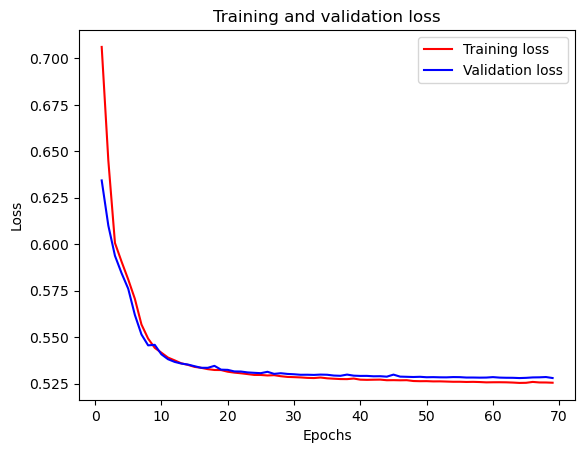

In [130]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=SEED)
# 얼리 스탑핑 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 체크포인트 콜백 정의
checkpoint_path = "./model/model.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

# 인코더 및 디코더 모델 빌드
input_shape = x_train.shape[1:]
encoder = build_encoder(input_shape)
decoder = build_decoder(encoder.output_shape[1:])

# 오토인코더 모델 생성
input_img = tf.keras.Input(shape=input_shape)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = tf.keras.Model(input_img, decoded)

# 모델 컴파일 및 학습
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=10, shuffle=True,
                          validation_data=(x_val, x_val), callbacks=[early_stopping, checkpoint])
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 학습 및 검증 손실 그래프 시각화
plot_loss(history)

*  Early_stopping을 이용해 지표의 값이 개선이 더이상 없을 때 모델의 훈련 종료
*  Checkpoint를 설정하여 가장 성능이 좋은 모델 저장

##### 디코더를 통해 복원한 이미지와 원본 이미지 비교

1/1 [==============================] - 0s 21ms/step


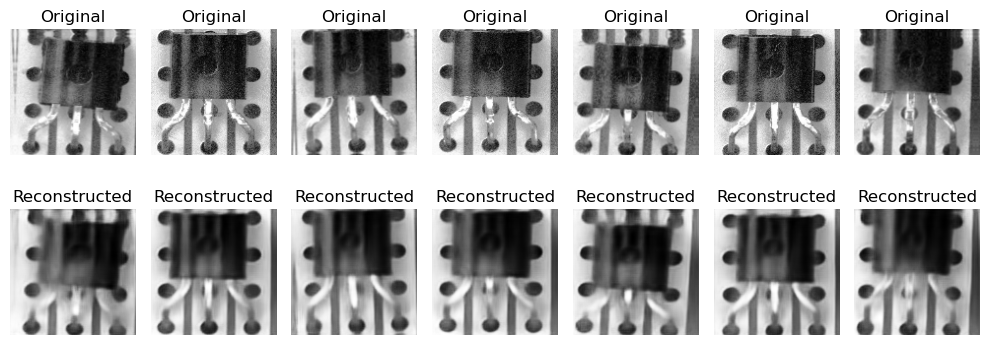

In [138]:
# 예측된 이미지 생성 함수
def generate_images(model, test_input):
    reconstructed_images = model.predict(test_input)
    return reconstructed_images

# 원본 이미지와 복원 이미지 비교 함수
def plot_images(original_images, reconstructed_images, num_images=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # 원본 이미지
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(input_shape[:-1]), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # 복원 이미지
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape(input_shape[:-1]), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 테스트 이미지 선택 (여기서는 검증 데이터셋 사용)
num_images_to_show = 7
test_images = x_val[:num_images_to_show]

# 복원 이미지 생성
reconstructed_images = generate_images(autoencoder, test_images)

# 이미지 비교하여 시각화
plot_images(test_images, reconstructed_images, num_images=num_images_to_show)

###### 재구성한 오차를 계산해서 임계점 설정

In [139]:
# 학습 데이터의 재구성 오차 계산
def calculate_reconstruction_errors(model, data):
    reconstructed_data = model.predict(data)
    reconstruction_errors = np.mean(np.abs(data - reconstructed_data), axis=(1, 2, 3))  # 각 데이터 포인트의 재구성 오차 계산
    return reconstruction_errors

# 가장 큰 재구성 오차 찾기
def find_largest_reconstruction_error(reconstruction_errors):
    max_error_threshold = np.percentile(reconstruction_errors, 99)  # 상위 99% 지점의 재구성 오차 임계값
    max_error = np.max(reconstruction_errors)  # 최대 재구성 오차 값
    return max_error_threshold
# 학습된 모델로 재구성 오차 계산
train_reconstruction_errors = calculate_reconstruction_errors(autoencoder, x_train)

# 가장 큰 재구성 오차 찾기
max_error = find_largest_reconstruction_error(train_reconstruction_errors)

print("가장 큰 재구성 오차:", max_error)

11/11 [==============================] - 1s 71ms/step
가장 큰 재구성 오차: 0.05262472104042371


* Threshold는 재구성한 오차 값에서 가장 큰 값으로 설정하는것이 일반적
* 상위 99% 설정한 결과 현재까진 가장 높은 정확도를 보임
* 해당 오차를 임계점으로 설정하고 해당 임계점보다 높은 오차인 경우 이상데이터로 판단

###### 앞에서 설정된 임계 값을 토대로 test데이터에서 임계 값보다 큰 오차가 나오는 인덱스와 갯수 출력

In [140]:
# 임계값 설정
threshold = max_error

# 테스트 데이터의 재구성 오차 계산
test_reconstruction_errors = calculate_reconstruction_errors(autoencoder, x_test)

# 이상치 탐지
anomalies_indices = np.where(test_reconstruction_errors > threshold)[0]
num_anomalies = len(anomalies_indices)

print("이상치 개수:", num_anomalies)
print("이상치 인덱스:", anomalies_indices)

4/4 [==============================] - 1s 164ms/step
이상치 개수: 48
이상치 인덱스: [ 0  1  6  9 11 14 15 16 23 26 29 30 31 33 34 36 38 39 44 45 47 48 49 51
 53 55 57 60 61 63 65 69 74 77 79 80 81 85 86 87 88 90 91 92 93 94 98 99]


###### test데이터에서 이상 데이터로 판단한 이미지 출력

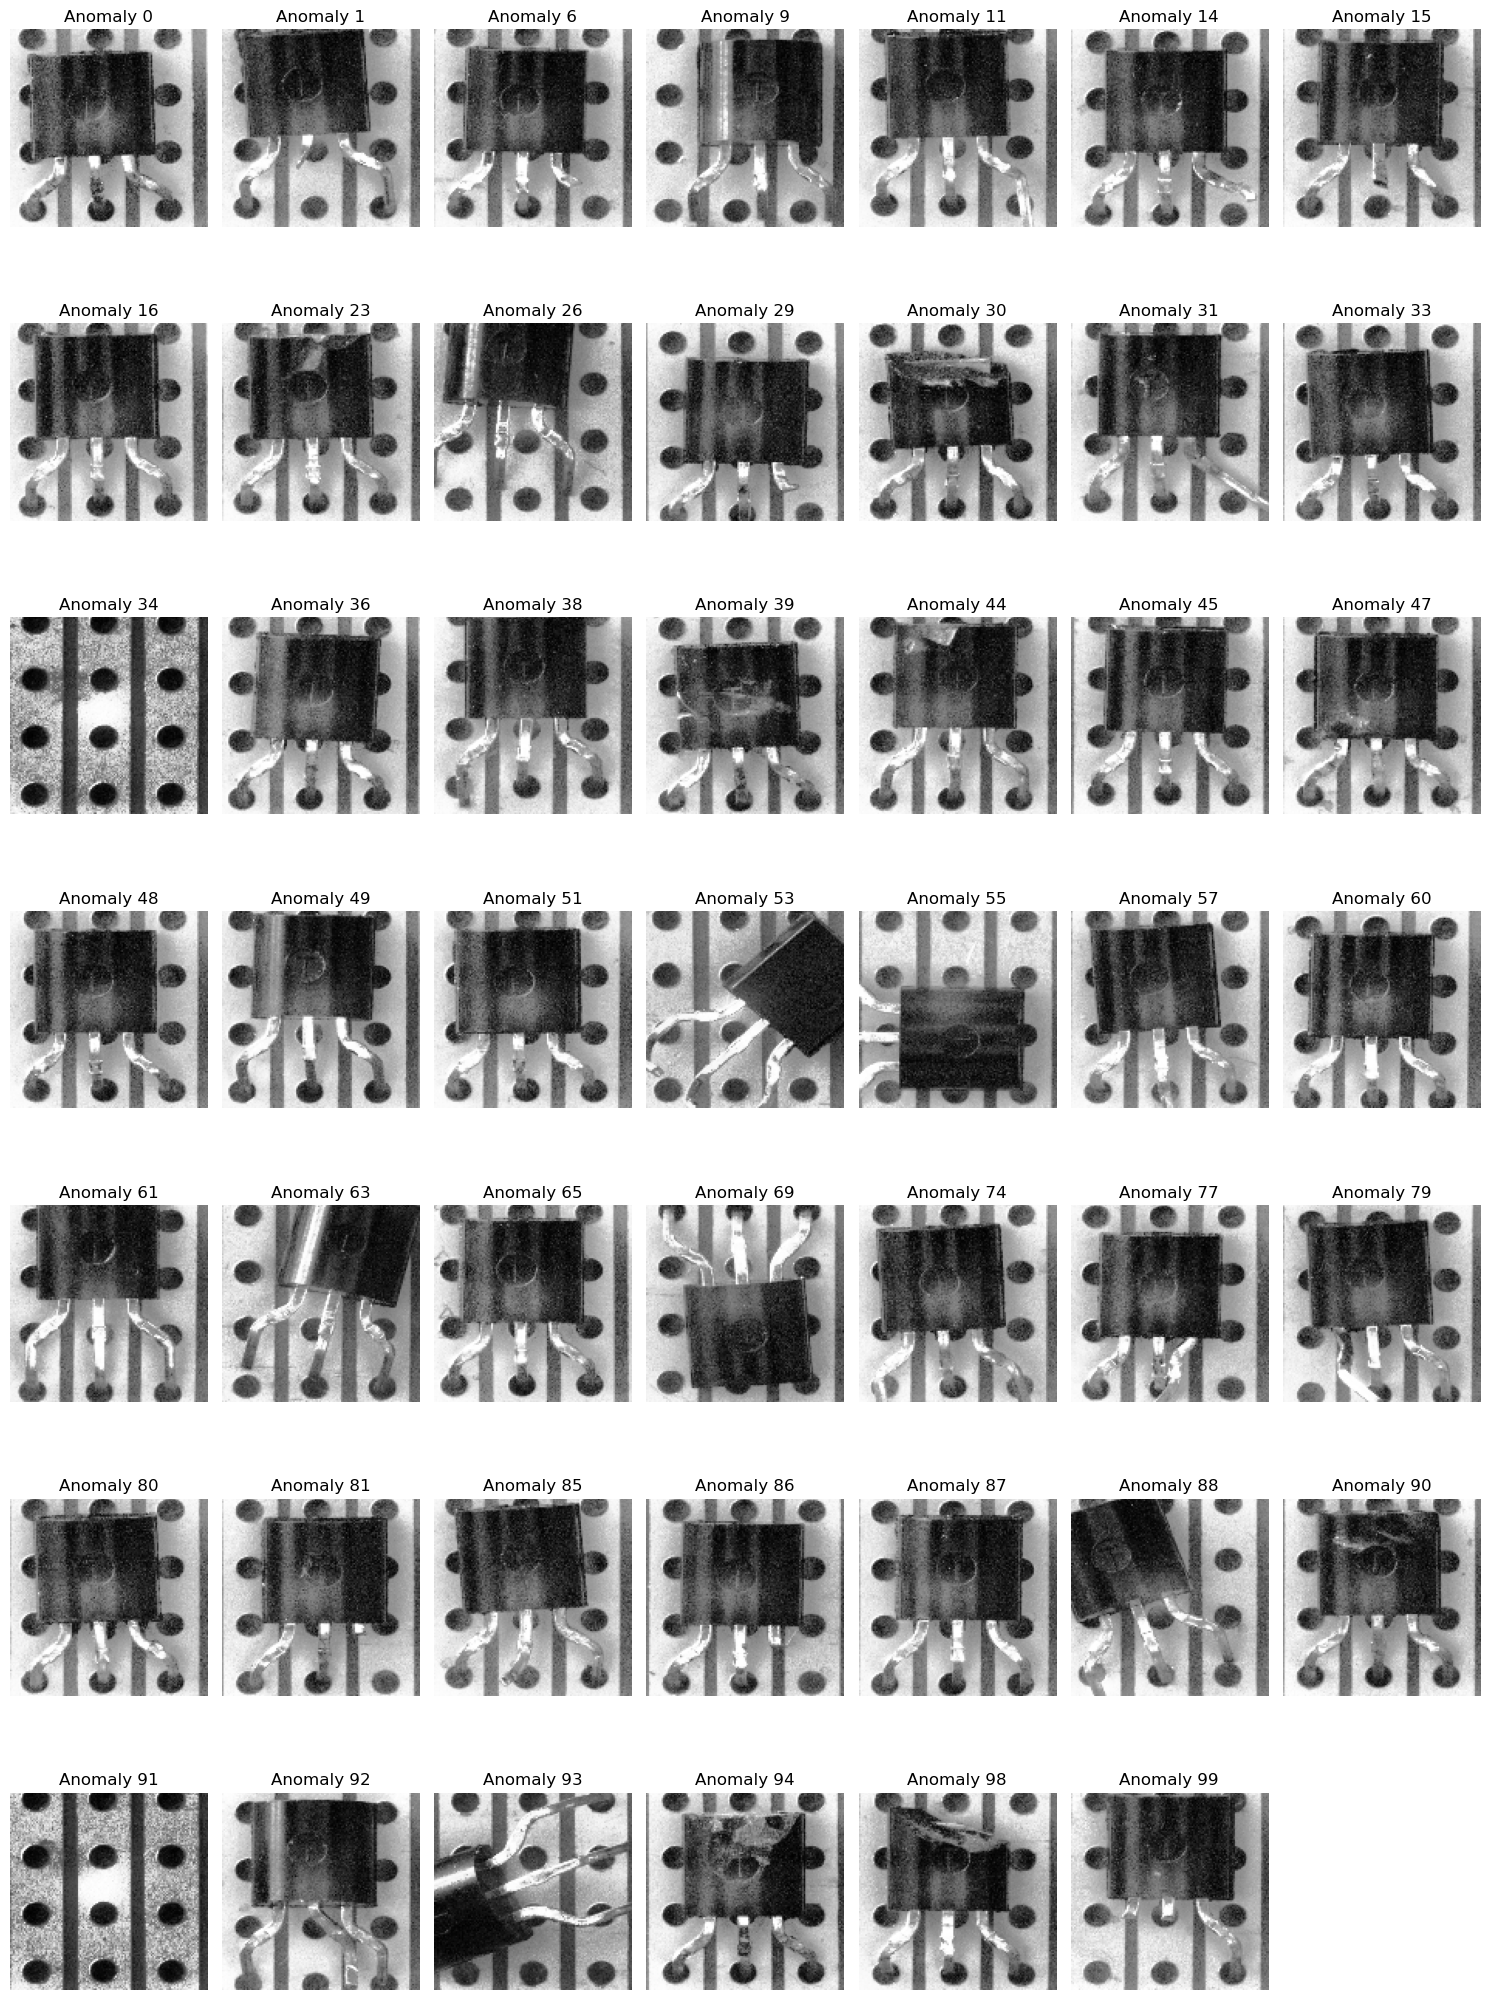

In [151]:
# 이상치로 탐지된 데이터 시각화
def plot_anomalies(data, anomalies_indices, num_cols=7):
    num_anomalies = len(anomalies_indices)
    num_rows = (num_anomalies + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(anomalies_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(data[idx].squeeze(), cmap='gray')  # 이미지 데이터의 경우 cmap='gray'로 설정
        plt.title(f"Anomaly {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 이상치로 탐지된 데이터 시각화
plot_anomalies(x_test, anomalies_indices)


###### 제출용 csv 생성

In [155]:
def create_submission_file(anomalies_indices, test_df, output_file='submission.csv'):
    # 모든 데이터를 0으로 초기화
    submission_df = pd.DataFrame({'id': test_df['id'], 'label': 0})

    # 이상치가 있는 인덱스에 해당하는 행을 1로 설정
    submission_df.loc[anomalies_indices, 'label'] = 1

    # submission.csv 파일로 저장
    submission_df.to_csv(output_file, index=False)

In [156]:
create_submission_file(anomalies_indices, test_df)

###### One-class SVM Model

In [143]:
from sklearn.svm import OneClassSVM

encoder_model = tf.keras.Model(input_img, encoded)

# 인코더 모델(CNN)
encoded_train = encoder_model.predict(x_train)
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))

# 인코딩
encoded_test = encoder_model.predict(x_test)
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

# StandardScaler 정규화도 시도해봤지만, 이상 데이터를 탐지하지 못함

best_score = -float("inf")
best_nu = None
best_model = None

for nu in [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4]:
    model = OneClassSVM(nu=nu)
    model.fit(encoded_train_flat)
    scores = model.decision_function(encoded_test_flat)
    score = sum(scores < 0)  # 이상치로 분류되는 샘플 수
    if score > best_score:
        best_score = score
        best_nu = nu
        best_model = model

print("Best nu:", best_nu)
print("Best score:", best_score)

# 이상치 탐지
pred = best_model.predict(encoded_test_flat)

anomalies_svm = np.where(pred == -1)[0]
print('이상치 개수 :', len(anomalies_svm))
print('이상치 인덱스 :', anomalies_svm)

4/4 [==============================] - 0s 13ms/step
Best nu: 0.4
Best score: 33
이상치 개수 : 33
이상치 인덱스 : [ 0  6  9 26 29 30 33 34 36 39 45 48 49 53 55 57 60 63 64 65 69 74 77 81
 86 87 88 90 91 92 93 94 98]


* 앞서 구현한 오토인코더의 인코더 모델을 활용하여 One-Class SVM 모델 학습 진행
* 오토인코더를 CNN으로 구현 -> 특징 추출에 유용
* StandardScaler 정규화 시도 -> 이상 데이터 탐지 X

###### PCA(주성분 분석)

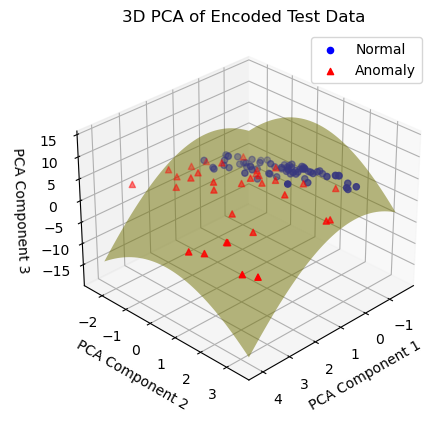

In [144]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 원-클래스 SVM을 사용하여 예측한 후 이상치와 정상치 인덱스를 분리
anomalies_indices_svm = np.where(pred == -1)[0]
normal_indices_svm = np.where(pred == 1)[0]

# PCA를 사용하여 3차원으로 축소
pca = PCA(n_components=3)
encoded_test_pca = pca.fit_transform(encoded_test_flat)

# 이상치와 정상치를 분리하여 시각화
anomalies_pca = encoded_test_pca[anomalies_indices_svm]
normal_pca = encoded_test_pca[normal_indices_svm]

# 3D 그래프 설정
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 이상치와 정상치를 다른 색상으로 시각화
ax.scatter(normal_pca[:, 0], normal_pca[:, 1], normal_pca[:, 2], c='b', marker='o', label='Normal')
ax.scatter(anomalies_pca[:, 0], anomalies_pca[:, 1], anomalies_pca[:, 2], c='r', marker='^', label='Anomaly')

# 그래프 설정
ax.set_title('3D PCA of Encoded Test Data')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()

# 결정 경계 평면 계산
# Grid 생성
xx, yy = np.meshgrid(np.linspace(encoded_test_pca[:, 0].min(), encoded_test_pca[:, 0].max(), 50),
                     np.linspace(encoded_test_pca[:, 1].min(), encoded_test_pca[:, 1].max(), 50))

# 평면 위의 점에 대해 SVM 예측 수행
zz = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point = np.array([xx[i, j], yy[i, j], 0]).reshape(1, -1)
        zz[i, j] = best_model.decision_function(pca.inverse_transform(point))[0]

# 결정 경계 평면 시각화
ax.plot_surface(xx, yy, zz, color='y', alpha=0.5, rstride=100, cstride=100)

ax.view_init(elev=30, azim=45)
# 그래프 표시
plt.show()

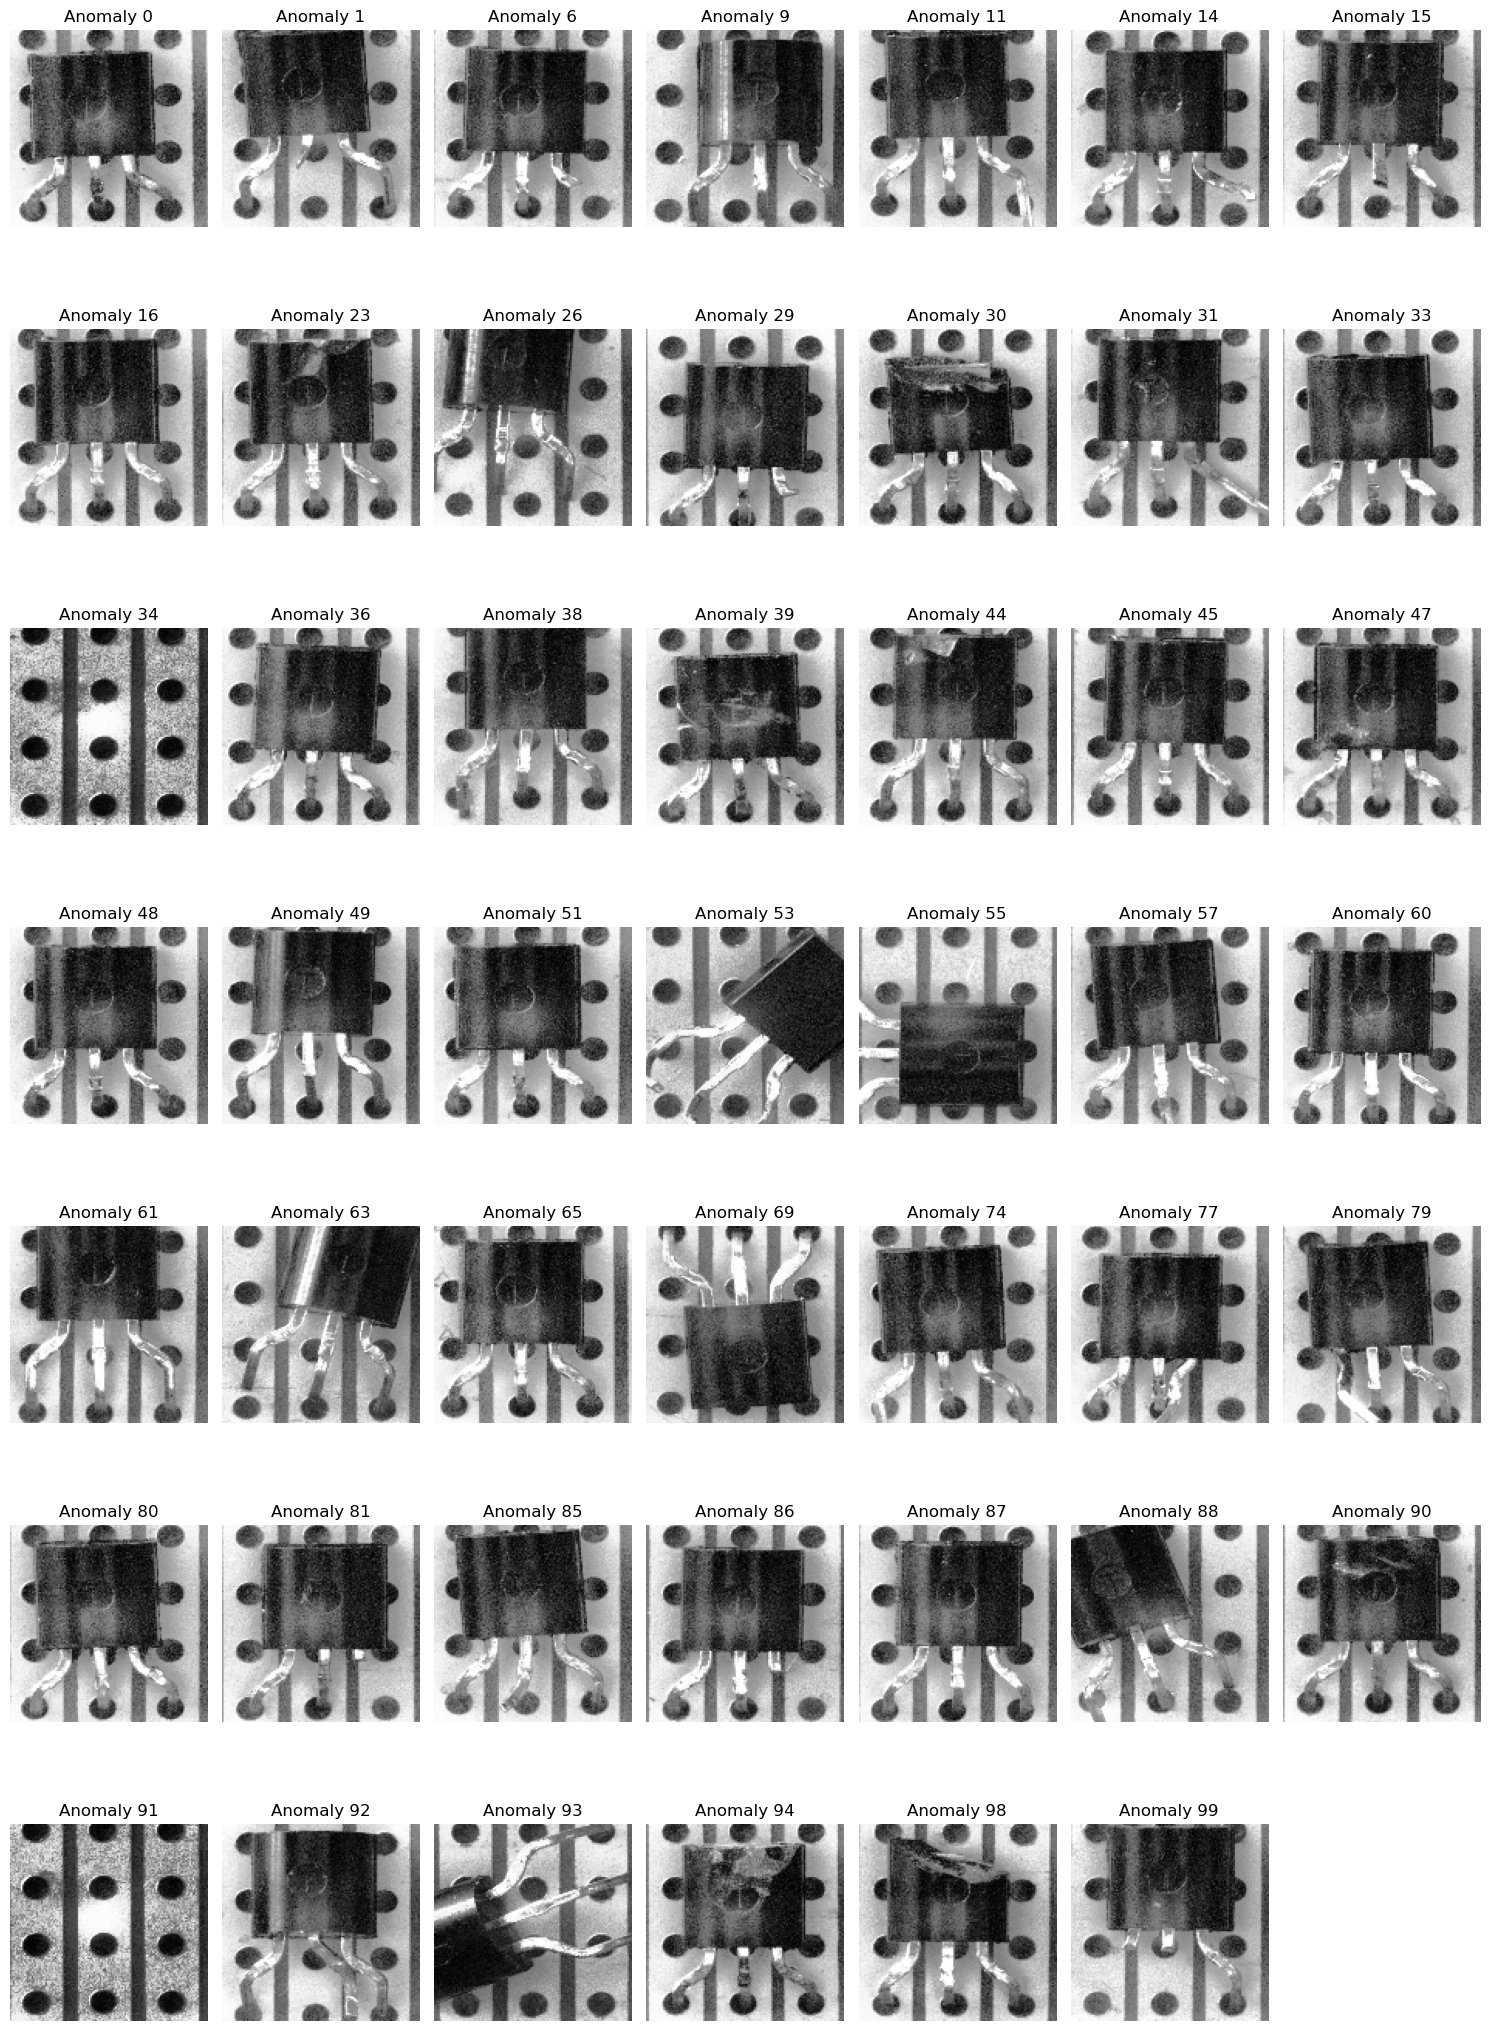

In [150]:
# 이상치로 탐지된 데이터 시각화
def plot_anomalies(data, anomalies_svm, num_cols=7):
    num_anomalies = len(anomalies_svm)
    num_rows = (num_anomalies + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 3 * num_rows))
    for i, idx in enumerate(anomalies_indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(data[idx].squeeze(), cmap='gray')  # 이미지 데이터의 경우 cmap='gray'로 설정
        plt.title(f"Anomaly {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 이상치로 탐지된 데이터 시각화
plot_anomalies(x_test, pred)

In [152]:
def create_submission_file(anomalies_svm, test_df, output_file='submission_svm.csv'):
    # 모든 데이터를 0으로 초기화
    submission_df = pd.DataFrame({'id': test_df['id'], 'label': 0})

    # 이상치가 있는 인덱스에 해당하는 행을 1로 설정
    submission_df.loc[anomalies_svm, 'label'] = 1

    # submission.csv 파일로 저장
    submission_df.to_csv(output_file, index=False)

In [153]:
create_submission_file(anomalies_svm, test_df)